<h3 style="color:#ff6600 ; text-align:left ; font-family: Verdana, serif;"><b>Exploratory Analysis</b></h3>

In [2]:
from keras.models import Sequential
from keras.layers import Convolution2D, Convolution1D, MaxPooling2D, MaxPooling1D, ZeroPadding2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.optimizers import SGD, Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.constraints import maxnorm
from keras.layers.advanced_activations import PReLU
from keras.layers.normalization import BatchNormalization
from keras.utils.visualize_util import model_to_dot

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, classification_report


import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use(['ggplot'])
%pylab inline

import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools  
from PIL import Image
import pandas as pd

from IPython.display import display, HTML, SVG
import json
import h5py
import os
import cPickle
import sys
import shutil
import glob

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns',None)

Using Theano backend.
WARNING (theano.configdefaults): Only clang++ is supported. With g++, we end up with strange g++/OSX bugs.


Populating the interactive namespace from numpy and matplotlib


<h4 style="color:#ff6600 ; text-align:left ; font-family: Verdana, serif;"><b>Visualizing the number of images per species</b></h4>

In [2]:
def choose_image_only(fl):
    '''
    This function returns true if the file is a png file.
    '''
    ext = (".jpg", ".jpeg", ".JPG", ".png")
    return fl.endswith(ext)


def get_number_of_images(root_dir):
    '''
    This function is used to get the number of images per species.
    Returns a dictionary
    '''
    sp_images = {}
    di = os.walk(root_dir)
    try:
        while True:
            try:
                path, dirs, files = di.next()
                # Choose only the png files
                img_filenames = filter(choose_image_only, files)
                if img_filenames:
                    sp_name = os.path.basename(path)
                    sp_images[sp_name] = len(img_filenames)
            except StopIteration:
                break
        return sp_images
    except Exception as e:
        print "Error !::", str(e)

num_imgs_per_species = get_number_of_images('./work/grayscale_consol/')

df_plt_count = pd.DataFrame(num_imgs_per_species.items(), columns=['species', 'count'])
df_plt_count.sort_values(by='count', ascending = True, inplace=True)
data = [go.Bar(
            x=df_plt_count['count'],
            y=df_plt_count['species'],
            orientation = 'h'
        )]
ycoord=df_plt_count['species']
x1 = df_plt_count['count']
annotations = [dict(
                x=xi,
                y=yi,
                text=str(xi),
                xanchor='left',
                yanchor='bottom',
                showarrow=False,
            ) for xi, yi in zip(x1, ycoord)]
layout = go.Layout(
    annotations=annotations,
    title='Number of Images for each Species',
    xaxis=dict(
        title='Count',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#ff6600'
            
        ),
        
    ),
    yaxis=dict(
            #title='Species',
            titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#ff6600'
            ),
        tickangle=-45
        
    ),
    margin=go.Margin(
                    l=150,
                    pad=4
                    )
)

fig = go.Figure(data=data, layout=layout)
fig['layout'].update(width=800)
py.iplot(fig, filename='pandas-horizontal-bar')

***The images were split into a train, validation and test set in 70-20-10 respectively for each of the species***

In [3]:
train_imgs_per_species = get_number_of_images('./work/g_train/')
test_imgs_per_species = get_number_of_images('./work/g_test/')
val_imgs_per_species = get_number_of_images('./work/g_val/')
df_plt_count1 = pd.DataFrame(train_imgs_per_species.items(), columns=['species', 'training_count'])
df_plt_count1.sort_values(by='training_count', ascending = True, inplace=True)

df_plt_count2 = pd.DataFrame(test_imgs_per_species.items(), columns=['species', 'test_count'])
df_plt_count2.sort_values(by='test_count', ascending = True, inplace=True)

df_plt_count3 = pd.DataFrame(val_imgs_per_species.items(), columns=['species', 'validation_count'])
df_plt_count3.sort_values(by='validation_count', ascending = True, inplace=True)


result = pd.merge(df_plt_count1, df_plt_count2, on='species', how='inner')
result = pd.merge(result, df_plt_count3, on='species', how='inner')
result

,species,training_count,test_count,validation_count
0,Panthera_pardus_TZ,155,21,38
1,Tragelaphus_scriptus_TZ,223,30,55
2,Pecari_tajacu_SR,837,116,209
3,Cercocebus_sanjei_TZ,884,122,221
4,Nesotragus_moschatus_TZ,919,127,229
5,Tayassu_pecari_SR,938,130,234
6,Dasyprocta_leporina_SR,1120,155,280
7,Psophia_crepitans_SR,1168,162,292
8,Potamochoerus_larvatus_TZ,1176,163,293
9,Cephalophus_harveyi_TZ,2757,382,689


<h4 style="color:#ff6600 ; text-align:left ; font-family: Verdana, serif;"><b>Example of Image Augmentation on the training set</b></h4>

In [4]:
datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
img_path = './images/703_Matundu_CT6 - 3250R_Panthera_pardus.jpg'
img = load_img(img_path)  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
print x.shape
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1, save_to_dir='./images/preview/', save_prefix='Panther_augmented', save_format='jpeg'):
    i += 1
    if i > 17:
        break  # otherwise the generator would loop indefinitely

(553, 815, 3)


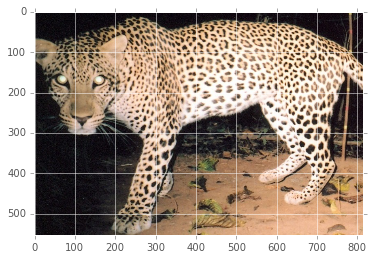

In [5]:
img_path = './images/703_Matundu_CT6 - 3250R_Panthera_pardus.jpg'
img = load_img(img_path)
plt.imshow(img)
plt.show()
imagesList=''.join( ["<img style='width: 120px; margin: 0px; float: left; border: 1px solid black;' src='%s' />" % str(s) 
                 for s in sorted(glob.glob('./images/preview/*.jpeg')) ])
display(HTML(imagesList))

<h4 style="color:#ff6600 ; text-align:left ; font-family: Verdana, serif;"><b>Architecture</b></h4>

***As mentioned in the Karapathy's tutorial formula for calculating how many neurons “fit” is given by ***

$\dfrac {(W−F+2P)}{S} +1 $

***where (W) : input volume size , (F) : the receptive field size of the Conv Layer neurons , (S): the stride with which they are applied , (P) : the amount of zero padding used on the border***

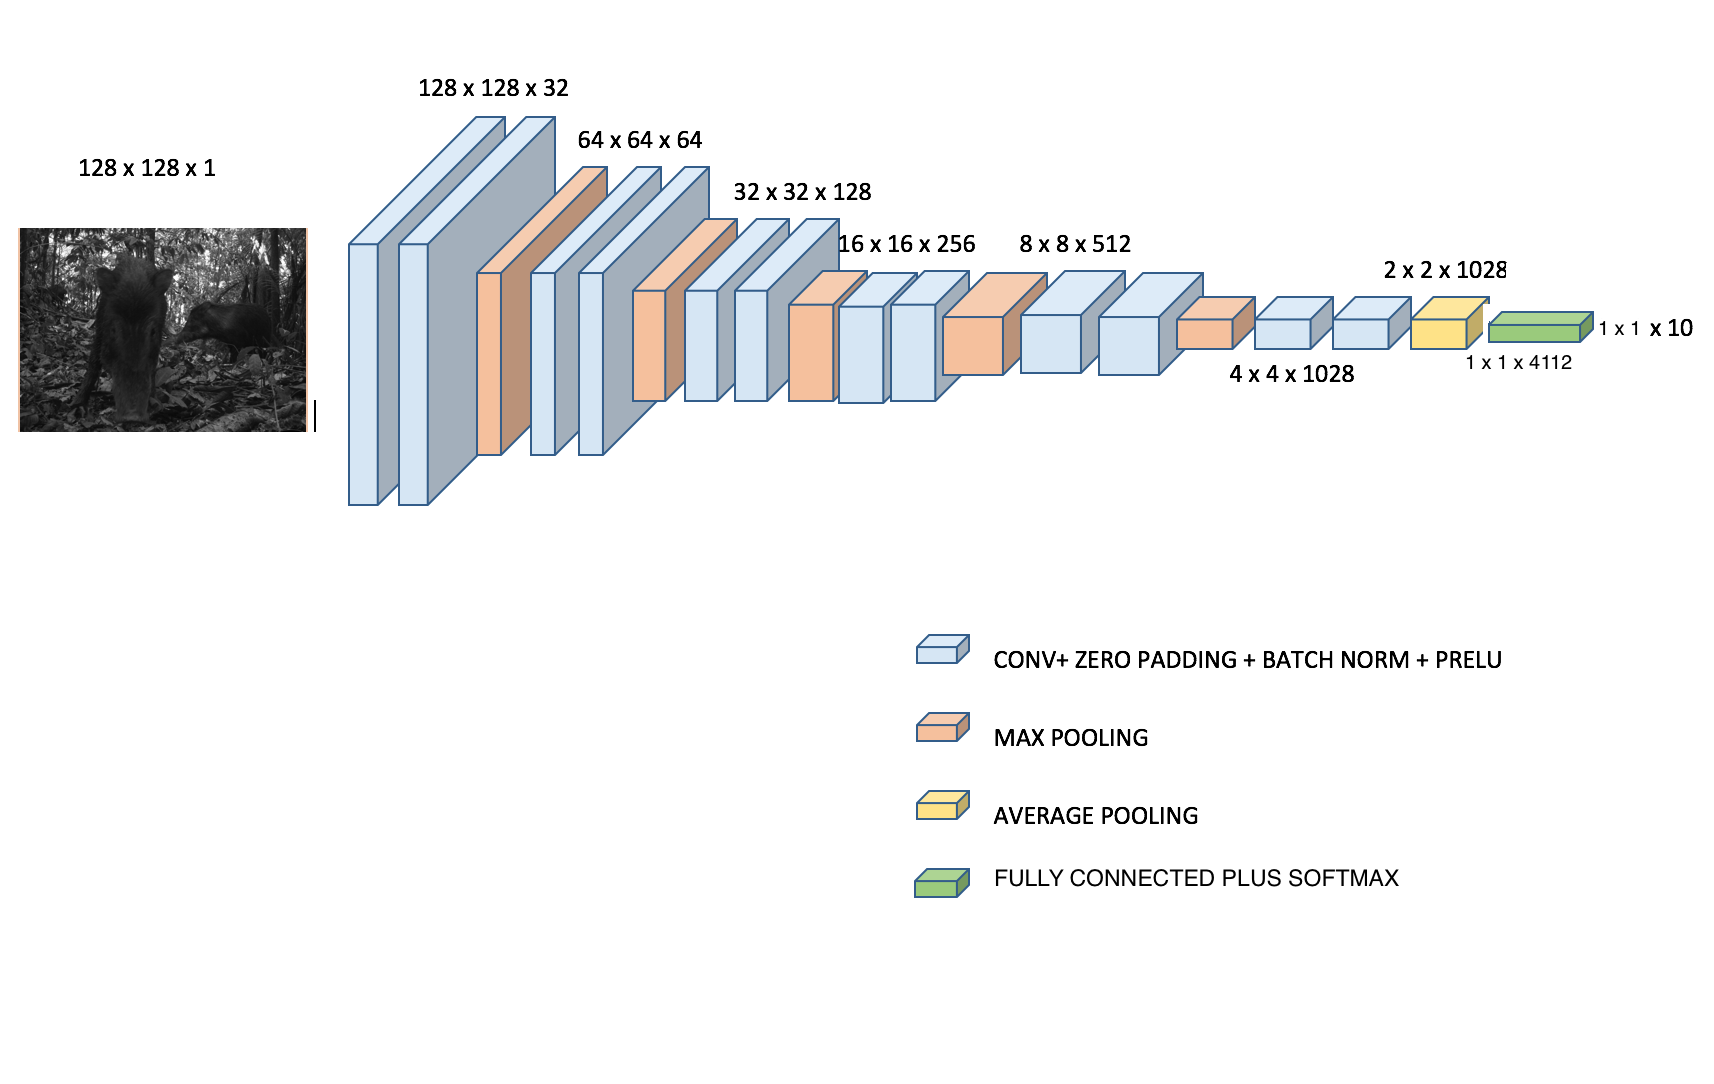

In [6]:
from IPython.display import Image as dispIm
PATH = "./images/arch.png"
dispIm(filename = PATH, width=500, height=500)

*** Formal definition of PRELU***

$f(y_i) = max(0, y_i) + a_i min(0, y_i)$

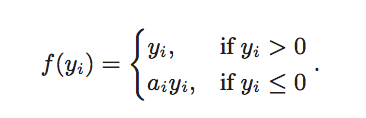

In [7]:
from IPython.display import Image as dispIm
PATH = "./images/prelu1.png"
dispIm(filename = PATH, width=200, height=200)

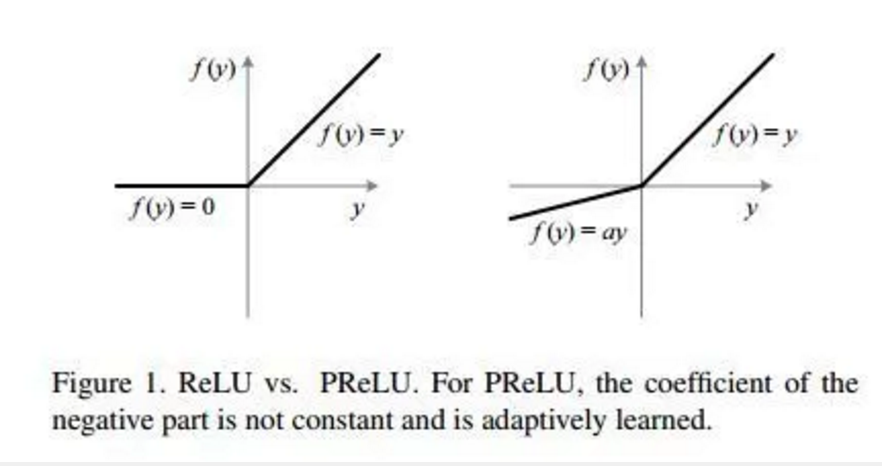

In [10]:
from IPython.display import Image as dispIm
PATH = "./images/PRELU.png"
dispIm(filename = PATH, width=500, height=500)

***Visualize the layers in the model***

In [11]:
from keras.models import load_model
model = load_model('./work/CNN_12/temp_model.h5')

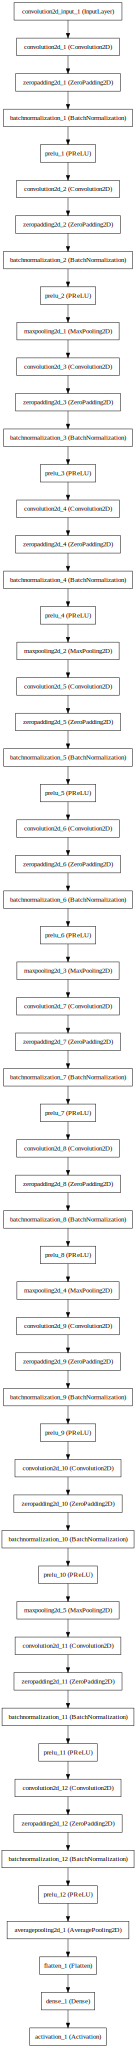

In [13]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))